In [1]:
from random import uniform
from dpi import *
import random


In [2]:
dp = Dilema(2, -1, 3, 0)

# Investigacion estrategia


## Exploracion de algoritmo genético



Debido a la naturaleza de los torneos evolutivos vamos a explorar la posibilidad de generar una estrategia mediante un algoritmo genetico, ya que la mayoria del cógigo necesario ya está implementado.

El primer paso que vamos a hacer es tratar de parametrizar las estrategias del juego, de modo que si encontramos valores adecuados para los parametro entonces encontraremos buenas estrategias para el juego, nos planteamos los siguientes requisitos para una buena parametrización.

1. Las estrategias deben permitir reaccionar a las jugadas del rival (Reactividad).
2. Tiene que ser posible parametrizar estrategias simples como la de tft, esto en un futuro nos permitira comprobar si el algoritmo acaba prefiriendo estas estrategias, que ya conocemos

La primera idea que hemos tenido para basar nuestra estrategia en parámetros es que los parámetros sean pesos que se multiplican por unas variables que encapsulan el estado de la partida para y que el resultado de la suma ponderada sirva para decidir si el agente coopera o deserta.

## $(\sum_{}^{}P_{i}C_{i}) + S = D$

$ -1 \le  P \le 1 $ peso: negativo tiende a desertar positivo a colaborar.  
$ 0 \le  C \le 1 $  caracteristica: dice cuanto se cumple una caracteristica en la partida.  
$ -1 \le  S \le 1 $  sesgo: sirve para hacer que la respuesta tienda a algo por defecto y marca la decisión de la primera ronda.  
$ D $ Decisión: Se interpreta viendo si es negativa -> C o positiva -> D.  


In [3]:
#Vamos a implementar un agente cuya estrategia queda definida por parámetros de este modo.
from numpy import dot

class Agente_parametros(Agente):
    def __init__(self, parametros:[float, ...], dilema:Dilema = dp):
        super().__init__(dilema)
        self.parametros = parametros  
    
    def generar_decision(self):
        lista_caracteriticas = [0 for i in range(len(self.parametros) - 1)]
        puntos_interes = [1, 3, 5, 10]
        
        i = 0
        
        for punto in puntos_interes:
            if len(self.resultados_partida) >= punto:
                lista_caracteriticas[i] = sum(self.resultados_partida.lista_jugadas_a1[-punto:])/punto
                lista_caracteriticas[i + 1] = sum(self.resultados_partida.lista_jugadas_a1[-punto:])/punto
                lista_caracteriticas[i + 2] = punto - (sum(self.resultados_partida.lista_jugadas_a1[-punto:]))/punto
                lista_caracteriticas[i + 3] = punto - (sum(self.resultados_partida.lista_jugadas_a1[-punto:]))/punto
                i += 4
            else:
                break
                
        decision = float(dot(self.parametros[:-1], lista_caracteriticas) + self.parametros[-1])
        
        if decision <= 0:
            return 0
        else:
            return 1
                
                                

In [4]:
def generar_parametros_random(n):
    return [uniform(-1, 1) for _ in range(n)]

In [5]:
parametros_random =  generar_parametros_random(17)
agente_parametros_random = Agente_parametros(parametros_random, dp)
defector = Defector(dp)
tft = Tft(dp)
agente_random = Agente_random(dp)

lista_jugadores = [agente_parametros_random, defector, tft]


In [6]:
partida = Partida(dp, agente_parametros_random, agente_random, n_rondas=30)
partida.simular_partida()
print(partida.resultados_partida)

(2)C | C(2)
(2)C | C(2)
(2)C | C(2)
(2)C | C(2)
(-1)C | D(3)
(0)D | D(0)
(0)D | D(0)
(0)D | D(0)
(0)D | D(0)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
(0)D | D(0)
(3)D | C(-1)
(0)D | D(0)
(3)D | C(-1)
(0)D | D(0)
(3)D | C(-1)
(3)D | C(-1)
(0)D | D(0)
(0)D | D(0)
(0)D | D(0)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
(3)D | C(-1)
Total: 52 | -4



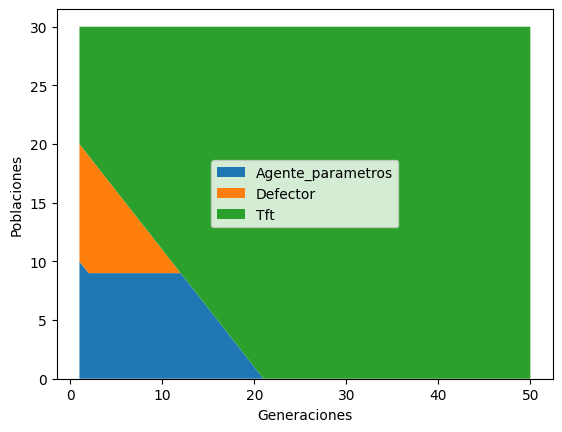

In [7]:
torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=50, error=0.01, polacion_inicial=30, n_rondas=10)
torneo_evolutivo.simular()
torneo_evolutivo.dibujar_resultados()

Como se puede ver hemos coneguido generar una estrategia reactiva, y que ademas de puede ajustar a estrategias como tft:

-1 * C op en la ultima ronda +1 * D op en la ultima ronda - 0.1

Sin embargo no consigue buenos resultados a la hora de enfrentarlo con estrategias conocidas

Ahora vamos a modificar el torneo generativo para tratar de generar una serie de parametros optimos para jugar a este juego, en concreto modificaremos la parte en la que se extinguen y se reproducen los agentes añadiendo los siguientes conceptos:

- Reproduccion: Se combinan parametros de agentes exitosos para generar nuevos agentes.
- Mutación: Los agentes nuevos pueden presentar diferencias aleatorias frente a sus progenitores.
- Supervivencia del mas fuerte: Los agentes que mejor lo hagan son preservados sin mutaciones.
- Extincion: Igual a como se implementaba anteriormente.


In [8]:
class Poblacion:
    def __init__(self, poblacion_inicial):
        self.dic_poblacion = {Agente_parametros(generar_parametros_random(17)):0.0 for _ in range(poblacion_inicial)}

    @property
    def lista_poblacion(self):
        return list(self.dic_poblacion.keys())

    def ordenar_dic_poblacion(self):
        self.dic_poblacion = dict(sorted(self.dic_poblacion.items(), key=lambda tup: tup[1], reverse=True))

    def eliminar_n_peores(self, n):
        for i in range(n):
            self.dic_poblacion.popitem()

    def reproducir_n_mejores(self, n, p_mutacion = 0.5):
        def mutar_agente(agente:Agente_parametros):
            for i in range(len(agente.parametros)):
                if random.random() < p_mutacion:
                    agente.parametros[i] = uniform(-1, 1)
                    
        agentes_poblacion = list(self.dic_poblacion.keys())
        mejores_poblacion = agentes_poblacion[:n]
        
        hijos = []
        
        for i in range(n):
            padre_a = random.choice(mejores_poblacion)
            padre_b = random.choice(mejores_poblacion)
            
            punto_corte = randrange(0,17)
            
            parametros_hijo = padre_a.parametros[0:punto_corte] + padre_b.parametros[punto_corte:]
            
            hijos.append(Agente_parametros(parametros_hijo))
            
        for hijo in hijos:
            mutar_agente(hijo)
            self.dic_poblacion[hijo] = 0.0
        

    def gestionar_evolucion(self, repr_int):
        #Mejorar la gestion de los casos de empate
        self.ordenar_dic_poblacion()
        self.eliminar_n_peores(repr_int)
        self.reproducir_n_mejores(repr_int)
        


In [9]:
class Evolucionar:

    def __init__(self, n_rondas: int = 100,
                       error: float = 0.0,
                       probabilidad_de_finalizar: float = 0.0,
                       generaciones: int = 100,
                       repeticiones: int = 1,
                       reprodctividad: float = 0.05,
                       poblacion_inicial: int = 100,
                       dilema = Dilema(2, -1, 3, 0)):

        self.n_rondas = n_rondas
        self.error = error
        self.probabilidad_de_finalizar = probabilidad_de_finalizar
        self.repeticiones = repeticiones
        self.generaciones = generaciones
        self.reproductividad = reprodctividad
        self.dilema = dilema
        self.poblacion_inicial = poblacion_inicial
        self.poblacion = Poblacion(self.poblacion_inicial)
        self.repr_int = int(self.poblacion_inicial * self.reproductividad)


    #Hay que gestionar los casos de empates
    def simular(self, imprimir = False):
        for generacion in range(self.generaciones):
            torneo_iterado = Torneo(self.poblacion.lista_poblacion, self.n_rondas, self.probabilidad_de_finalizar,self.error, self.repeticiones, self.dilema)
            torneo_iterado.simular_torneo()

            self.poblacion.dic_poblacion = torneo_iterado.ranking

            if imprimir:
                print(f"Generacion {generacion}: Poblacion: {self.poblacion.lista_poblacion[0].parametros}")
                #print(self.poblacion.dic_poblacion.values())

            self.poblacion.gestionar_evolucion(self.repr_int)
            
    def top_parametros(self, n):

        return  [agente.parametros for agente in self.poblacion.lista_poblacion[:n]]
            


In [10]:
evolucionar = Evolucionar(generaciones=100, poblacion_inicial=30, reprodctividad=0.5, n_rondas=15)
evolucionar.simular(imprimir=True)

Generacion 0: Poblacion: [0.5807769217712528, 0.5976178916906296, -0.8561831562458175, 0.780265326827152, 0.5659257874268884, 0.5502941028291042, -0.7779577837357481, 0.7051112115971219, -0.5439362852632619, -0.18318217224281197, -0.3075069567410862, 0.6728886531571445, 0.6070382818796163, -0.3844164095509297, 0.3454375194113326, -0.23705657142875136, 0.5282244029660936]
Generacion 1: Poblacion: [0.5807769217712528, 0.5976178916906296, -0.8561831562458175, 0.780265326827152, 0.5659257874268884, 0.5502941028291042, -0.7779577837357481, 0.7051112115971219, -0.5439362852632619, -0.18318217224281197, -0.3075069567410862, 0.6728886531571445, 0.6070382818796163, -0.3844164095509297, 0.3454375194113326, -0.23705657142875136, 0.5282244029660936]
Generacion 2: Poblacion: [0.5807769217712528, 0.5976178916906296, -0.8561831562458175, 0.780265326827152, 0.5659257874268884, 0.5502941028291042, -0.7779577837357481, 0.7051112115971219, -0.5439362852632619, -0.18318217224281197, -0.3075069567410862, 0

In [11]:
parametros_evolucionados = evolucionar.poblacion.lista_poblacion[0].parametros

In [12]:
agente_evolucionado = Agente_parametros(parametros_evolucionados, dp)
agente_evolucionado.nombre = "Evolucionado"
agente_parametros_random_1 = Agente_parametros(generar_parametros_random(17), dp)
agente_parametros_random_1.nombre = "Aleatorio_1"
agente_parametros_random_2 = Agente_parametros(generar_parametros_random(17), dp)
agente_parametros_random_2.nombre = "Aleatorio_2"
agente_parametros_random_3 = Agente_parametros(generar_parametros_random(17), dp)
agente_parametros_random_3.nombre = "Aleatorio_3"



lista_jugadores = [agente_evolucionado, agente_parametros_random_1, agente_parametros_random_2, agente_parametros_random_3]

Generacion 0: Poblacion: {'Evolucionado': 10, 'Aleatorio_1': 10, 'Aleatorio_2': 10, 'Aleatorio_3': 10}
Generacion 1: Poblacion: {'Evolucionado': 12, 'Aleatorio_1': 10, 'Aleatorio_2': 10, 'Aleatorio_3': 8}
Generacion 2: Poblacion: {'Evolucionado': 14, 'Aleatorio_1': 10, 'Aleatorio_2': 10, 'Aleatorio_3': 6}
Generacion 3: Poblacion: {'Evolucionado': 16, 'Aleatorio_1': 10, 'Aleatorio_2': 10, 'Aleatorio_3': 4}
Generacion 4: Poblacion: {'Evolucionado': 18, 'Aleatorio_1': 10, 'Aleatorio_2': 10, 'Aleatorio_3': 2}
Generacion 5: Poblacion: {'Evolucionado': 20, 'Aleatorio_1': 10, 'Aleatorio_2': 10, 'Aleatorio_3': 0}
Generacion 6: Poblacion: {'Evolucionado': 22, 'Aleatorio_1': 8, 'Aleatorio_2': 10, 'Aleatorio_3': 0}
Generacion 7: Poblacion: {'Evolucionado': 24, 'Aleatorio_1': 6, 'Aleatorio_2': 10, 'Aleatorio_3': 0}
Generacion 8: Poblacion: {'Evolucionado': 26, 'Aleatorio_1': 4, 'Aleatorio_2': 10, 'Aleatorio_3': 0}
Generacion 9: Poblacion: {'Evolucionado': 28, 'Aleatorio_1': 2, 'Aleatorio_2': 10, '

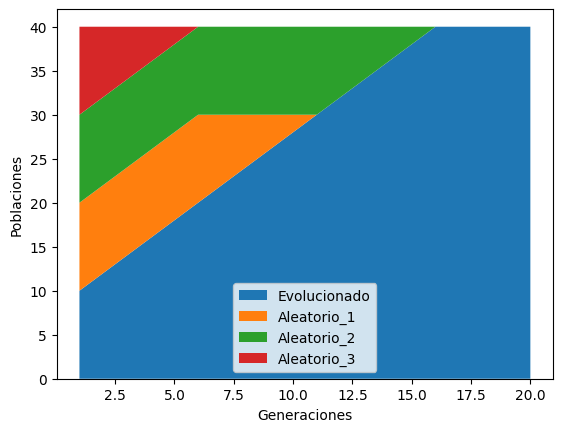

In [13]:
torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=20, error=0.01, polacion_inicial=40, n_rondas=10)
torneo_evolutivo.simular(imprimir=True)
torneo_evolutivo.dibujar_resultados()

Este punto parece muy prometedor ya que efectivamente hemos conseguido generar automaticamente estrategias que se comportan bien contra estrategias aleatorias basadas en parametros (con las que ha entrenado), veamos que sucede cuando la sacamos de su terreno y la enfrentamos contra estrategias que NO estan basadas en parametros.

Generacion 0: Poblacion: {'Agente_random': 13, 'Tft': 13, 'Evolucionado': 13}
Generacion 1: Poblacion: {'Agente_random': 12, 'Tft': 14, 'Evolucionado': 13}
Generacion 2: Poblacion: {'Agente_random': 11, 'Tft': 15, 'Evolucionado': 13}
Generacion 3: Poblacion: {'Agente_random': 10, 'Tft': 16, 'Evolucionado': 13}
Generacion 4: Poblacion: {'Agente_random': 10, 'Tft': 17, 'Evolucionado': 12}
Generacion 5: Poblacion: {'Agente_random': 10, 'Tft': 18, 'Evolucionado': 11}
Generacion 6: Poblacion: {'Agente_random': 10, 'Tft': 19, 'Evolucionado': 10}
Generacion 7: Poblacion: {'Agente_random': 10, 'Tft': 20, 'Evolucionado': 9}
Generacion 8: Poblacion: {'Agente_random': 10, 'Tft': 21, 'Evolucionado': 8}
Generacion 9: Poblacion: {'Agente_random': 10, 'Tft': 22, 'Evolucionado': 7}
Generacion 10: Poblacion: {'Agente_random': 10, 'Tft': 23, 'Evolucionado': 6}
Generacion 11: Poblacion: {'Agente_random': 10, 'Tft': 24, 'Evolucionado': 5}
Generacion 12: Poblacion: {'Agente_random': 10, 'Tft': 25, 'Evoluci

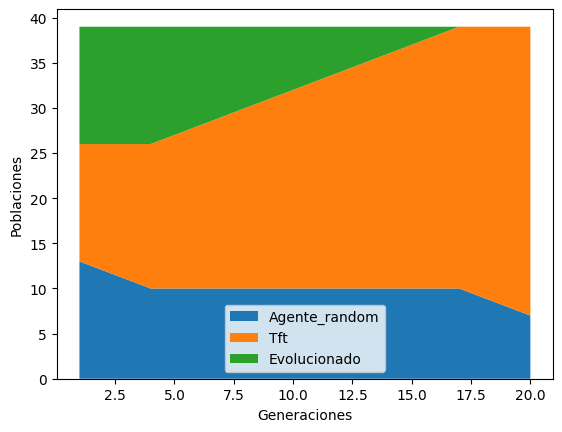

In [14]:
lista_jugadores = [agente_random, tft, agente_evolucionado]

torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=20, error=0.01, polacion_inicial=40, n_rondas=10)
torneo_evolutivo.simular(imprimir=True)
torneo_evolutivo.dibujar_resultados()


Por desgracia somos humillados por estrategias que no estan basadas en parametros como tft. En este punto abandonamos la idea de los algoritmos genéticos aunque creemos que seguramente se puedan conseguir resultados optimos, aqui van algunas ideas para mejorar los resultados que hemos obtenido:

- ajustar hiperparámetros: llevar a cabo más experiementos variando las generaciones, la probabilidad de mutacion , el numero de rondas, y otros valores que puedan afectar al resultado.
- Incluir estrategias conocidas en el proceso de evolucion: De este modo en cada generacion se seleccionaran no solo los que mejor lo hagan contra estrategias basadas en parametros sino que tambien influirá lo bien que lo hagan contra estrategias que no lo están.
- Cambiar por completo el uso de parametros: Durante el desarrollo de esta parte se nos ocurrio que podiamos interpretar la lista de jugadas del rival como un numero en binario, y pasarlo a decimal, de este modo el "genoma" sería una lista cuyos indices se correspondan con este numero, (que representa de forma unica las ultimas acciones del rival), y su valor fuera la respuesta del agente, Para implementar la estrategia hay que definir una profundidad, que sería el numero maximo de jugadas del rival que se van a analizar, segurtamente esta implementacion se vea mas favorecida por el proveso evolutivo.